
2. https://www.kaggle.com/competitions/playground-series-s5e3

In [1]:
# Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score, roc_curve
import warnings
warnings.filterwarnings("ignore")

# Set visualization style
sns.set_style("darkgrid")  # This sets the darkgrid background using seaborn
sns.set_palette("coolwarm")  # This sets the color palette


d:\Anaconda Installation\envs\Rec_sys_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load datasets
print("Loading datasets...")
df_train = pd.read_csv("./data/train.csv")
df_test = pd.read_csv("./data/test.csv")
sample_submission = pd.read_csv("./data/sample_submission.csv")

# Verify shapes
print("Train Data Shape:", df_train.shape)
print("Test Data Shape:", df_test.shape)
print("Sample Submission Shape:", sample_submission.shape)

Loading datasets...
Train Data Shape: (2190, 13)
Test Data Shape: (730, 12)
Sample Submission Shape: (730, 2)


In [3]:
# Display basic information
print("\nTrain Data Info:")
df_train.info()
print("\nTest Data Info:")
df_test.info()

# Display sample data
print("\nTrain Data Sample:")
display(df_train.head())
print("\nTest Data Sample:")
display(df_test.head())

# Check for missing values
print("\nMissing Values in Train:", df_train.isnull().sum().sum())
print("Missing Values in Test:", df_test.isnull().sum().sum())


Train Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2190 entries, 0 to 2189
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             2190 non-null   int64  
 1   day            2190 non-null   int64  
 2   pressure       2190 non-null   float64
 3   maxtemp        2190 non-null   float64
 4   temparature    2190 non-null   float64
 5   mintemp        2190 non-null   float64
 6   dewpoint       2190 non-null   float64
 7   humidity       2190 non-null   float64
 8   cloud          2190 non-null   float64
 9   sunshine       2190 non-null   float64
 10  winddirection  2190 non-null   float64
 11  windspeed      2190 non-null   float64
 12  rainfall       2190 non-null   int64  
dtypes: float64(10), int64(3)
memory usage: 222.6 KB

Test Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtyp

,id,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall
0,0,1,1017.4,21.2,20.6,19.9,19.4,87.0,88.0,1.1,60.0,17.2,1
1,1,2,1019.5,16.2,16.9,15.8,15.4,95.0,91.0,0.0,50.0,21.9,1
2,2,3,1024.1,19.4,16.1,14.6,9.3,75.0,47.0,8.3,70.0,18.1,1
3,3,4,1013.4,18.1,17.8,16.9,16.8,95.0,95.0,0.0,60.0,35.6,1
4,4,5,1021.8,21.3,18.4,15.2,9.6,52.0,45.0,3.6,40.0,24.8,0



Test Data Sample:


,id,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed
0,2190,1,1019.5,17.5,15.8,12.7,14.9,96.0,99.0,0.0,50.0,24.3
1,2191,2,1016.5,17.5,16.5,15.8,15.1,97.0,99.0,0.0,50.0,35.3
2,2192,3,1023.9,11.2,10.4,9.4,8.9,86.0,96.0,0.0,40.0,16.9
3,2193,4,1022.9,20.6,17.3,15.2,9.5,75.0,45.0,7.1,20.0,50.6
4,2194,5,1022.2,16.1,13.8,6.4,4.3,68.0,49.0,9.2,20.0,19.4



Missing Values in Train: 0
Missing Values in Test: 1


In [4]:
# Handle missing values in test data
print("Handling missing values...")
df_test['winddirection'].fillna(df_test['winddirection'].mean(), inplace=True)
print("Missing Values in Test after Imputation:", df_test.isnull().sum().sum())

Handling missing values...
Missing Values in Test after Imputation: 0


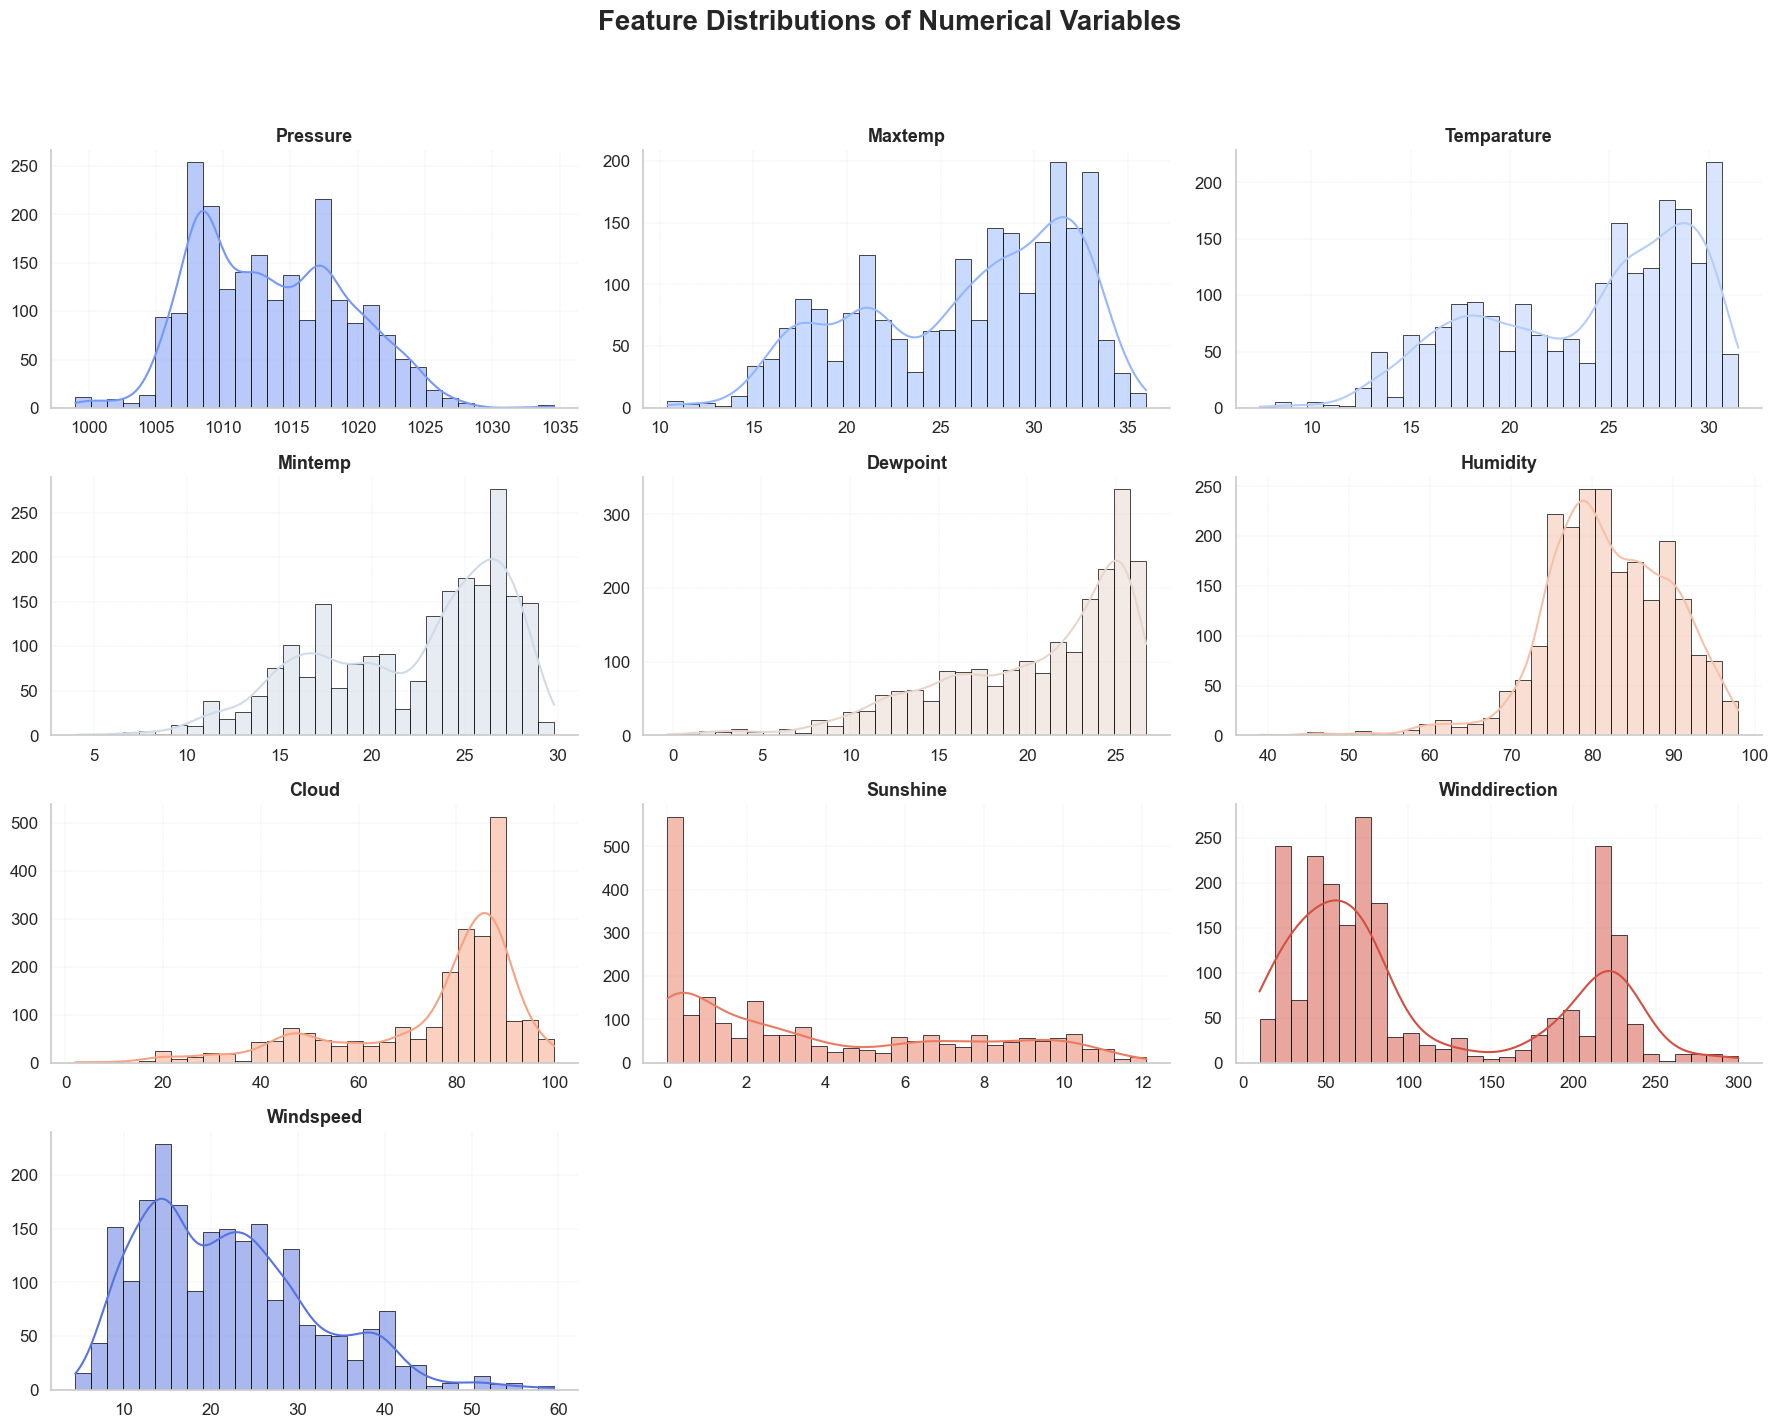

In [5]:
# Set a modern Seaborn style
sns.set(style="whitegrid", palette="pastel", font_scale=1.1)

# Define numerical features
numerical_variables = ['pressure', 'maxtemp', 'temparature', 'mintemp', 'dewpoint', 
                       'humidity', 'cloud', 'sunshine', 'winddirection', 'windspeed']

# Set up the matplotlib figure
plt.figure(figsize=(18, 14))
plt.suptitle("Feature Distributions of Numerical Variables", fontsize=20, fontweight='bold', y=1.02)

# Create subplots
for i, var in enumerate(numerical_variables, 1):
    plt.subplot(4, 3, i)
    sns.histplot(data=df_train, x=var, kde=True, bins=30,
                 color=sns.color_palette("coolwarm", len(numerical_variables))[i % len(numerical_variables)],
                 edgecolor='black', linewidth=0.5)
    
    plt.title(f'{var.capitalize()}', fontsize=13, weight='bold')
    plt.xlabel('')
    plt.ylabel('')
    plt.grid(True, linestyle='--', linewidth=0.3, alpha=0.6)
    sns.despine()

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()


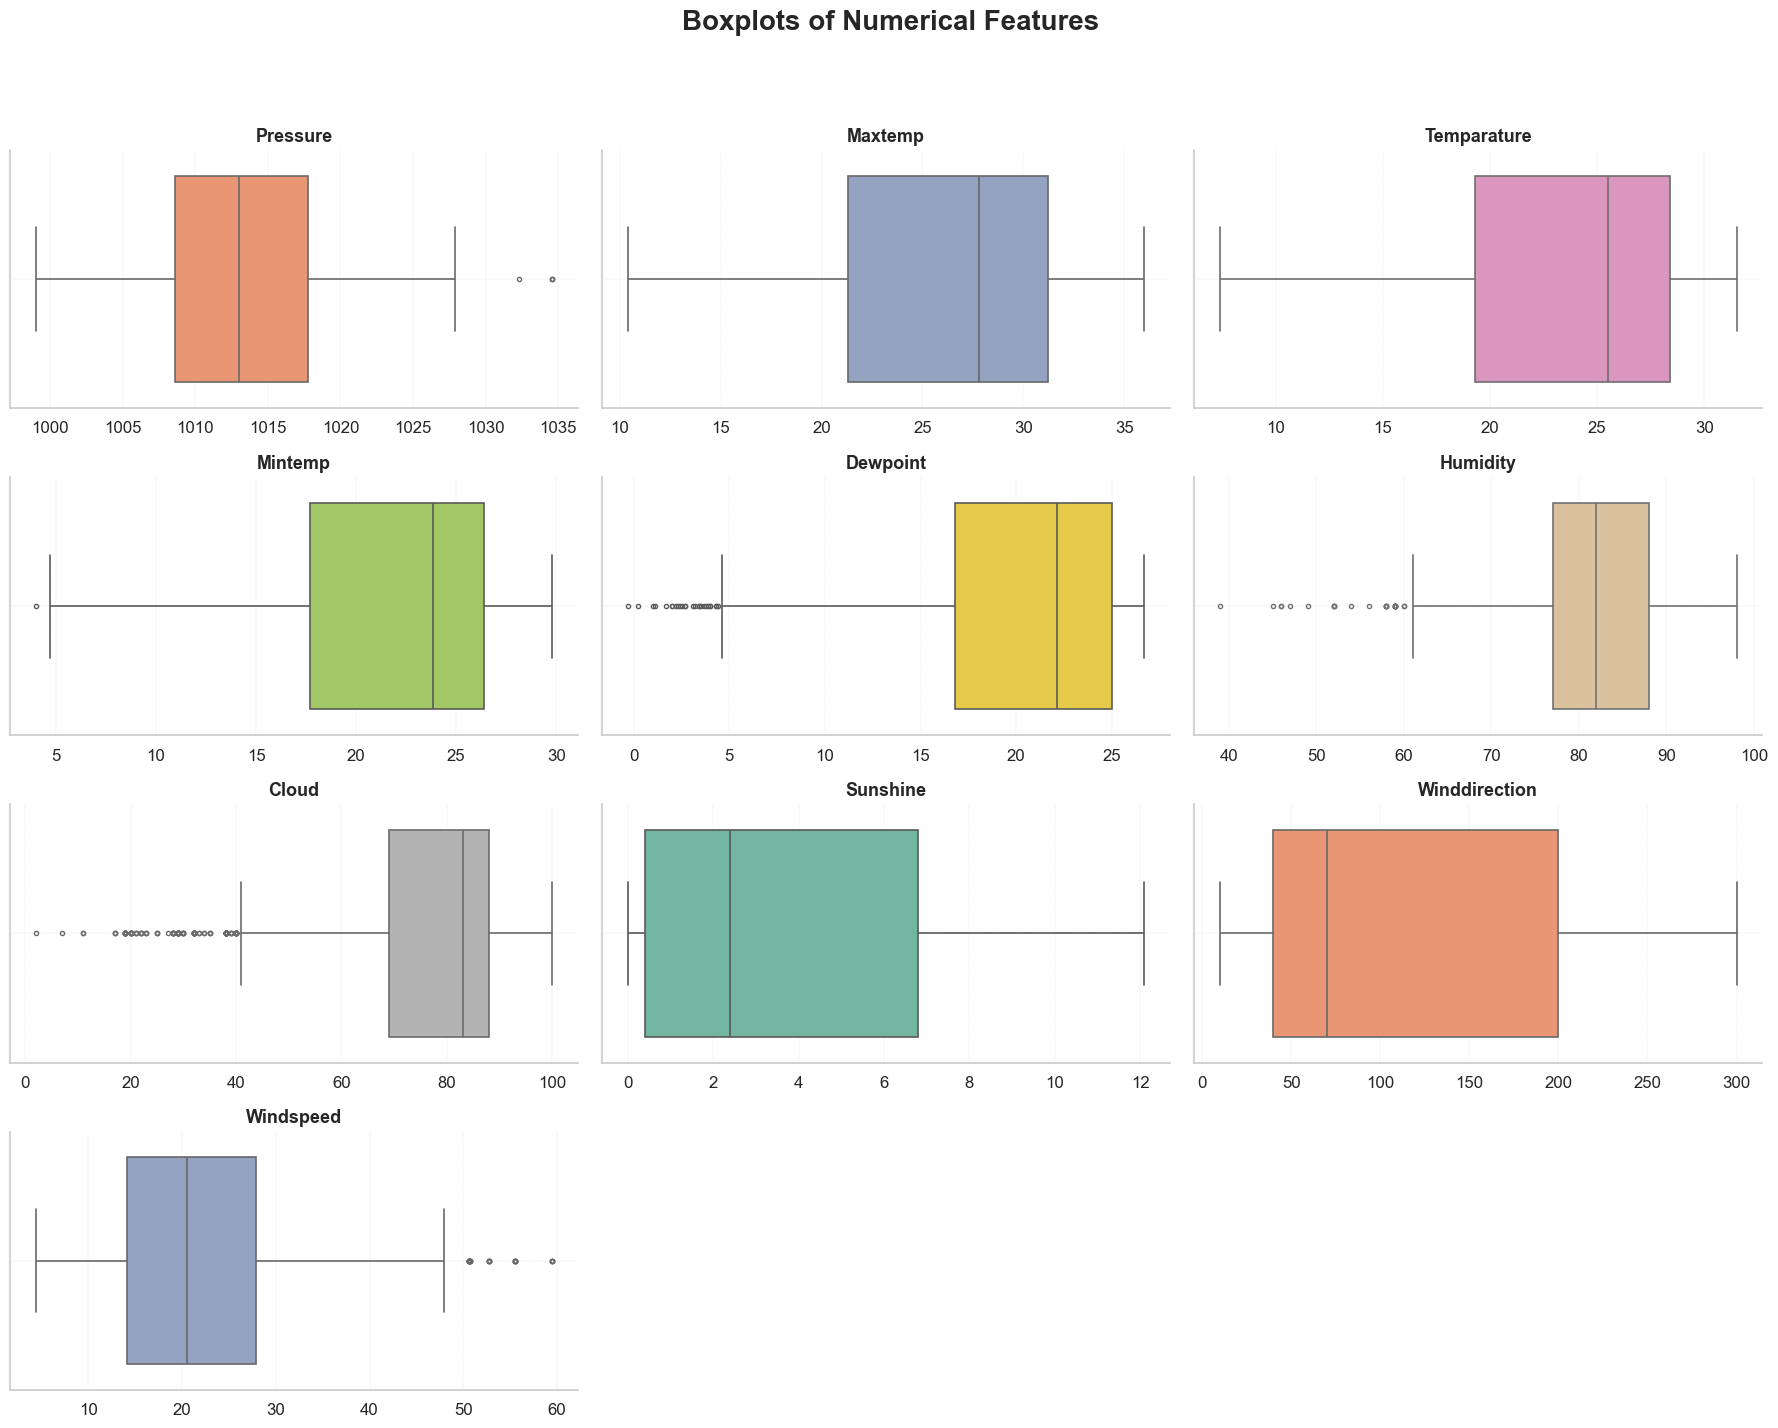

In [10]:
# Set Seaborn style and font scale
sns.set(style="whitegrid", palette="Set2", font_scale=1.1)

# Create boxplots with horizontal layout and better styling
plt.figure(figsize=(18, 14))
plt.suptitle("Boxplots of Numerical Features", fontsize=20, fontweight='bold', y=1.02)

for i, var in enumerate(numerical_variables, 1):
    plt.subplot(4, 3, i)
    sns.boxplot(data=df_train, x=var,
                color=sns.color_palette("Set2")[i % len(sns.color_palette("Set2"))],
                linewidth=1.2, fliersize=3)
    
    plt.title(f"{var.capitalize()}", fontsize=13, weight='bold')
    plt.xlabel('')
    plt.ylabel('')
    plt.grid(True, linestyle='--', linewidth=0.3, alpha=0.6)
    sns.despine()

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()


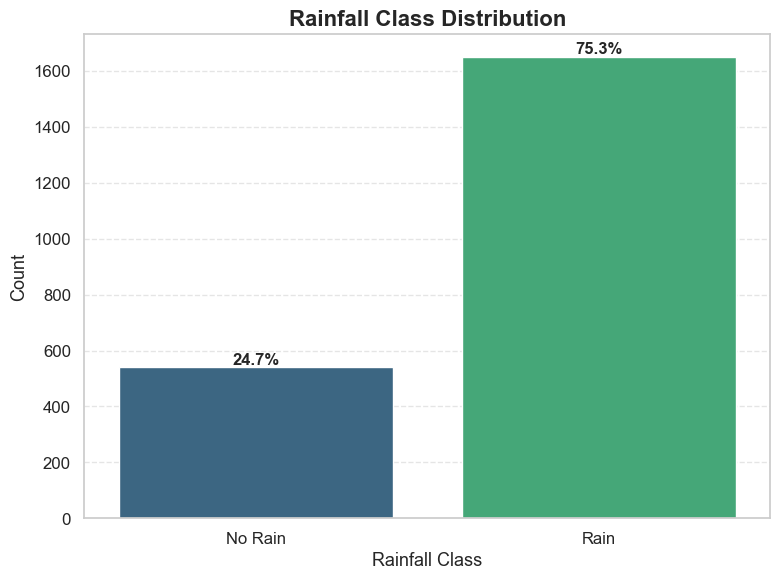

In [14]:
# Plot
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='rainfall', data=df_train, palette='viridis')

# Add percentages on top
total = len(df_train)
for p in ax.patches:
    count = p.get_height()
    percentage = f'{100 * count / total:.1f}%'
    ax.annotate(percentage, (p.get_x() + p.get_width() / 2., count),
                ha='center', va='bottom', fontsize=12, fontweight='bold')

# Labels
ax.set_xticklabels(['No Rain', 'Rain'], fontsize=12)
plt.title('Rainfall Class Distribution', fontsize=16, fontweight='bold')
plt.xlabel('Rainfall Class', fontsize=13)
plt.ylabel('Count', fontsize=13)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


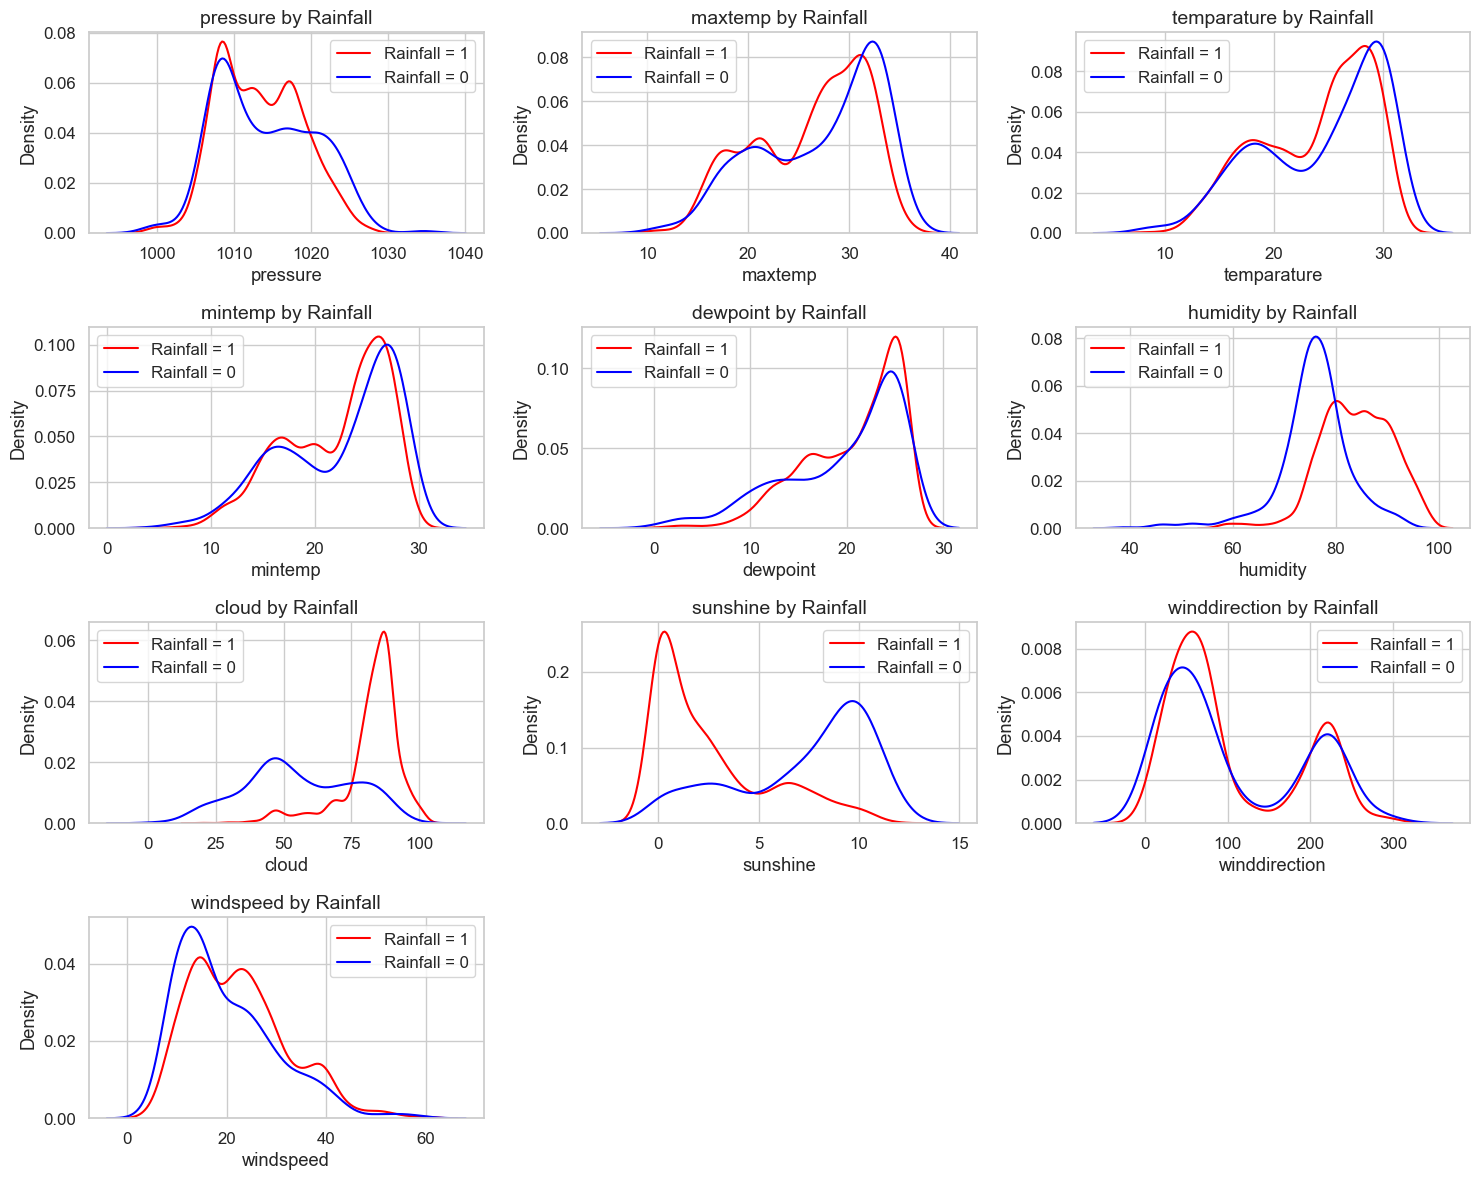

In [15]:
# KDE plots for feature-target relationships
plt.figure(figsize=(15, 12))
for i, var in enumerate(numerical_variables, 1):
    plt.subplot(4, 3, i)
    sns.kdeplot(data=df_train[df_train['rainfall'] == 1], x=var, label='Rainfall = 1', color='red')
    sns.kdeplot(data=df_train[df_train['rainfall'] == 0], x=var, label='Rainfall = 0', color='blue')
    plt.title(f'{var} by Rainfall', fontsize=14)
    plt.xlabel(var)
    plt.ylabel('Density')
    plt.legend()
plt.tight_layout()
plt.show()

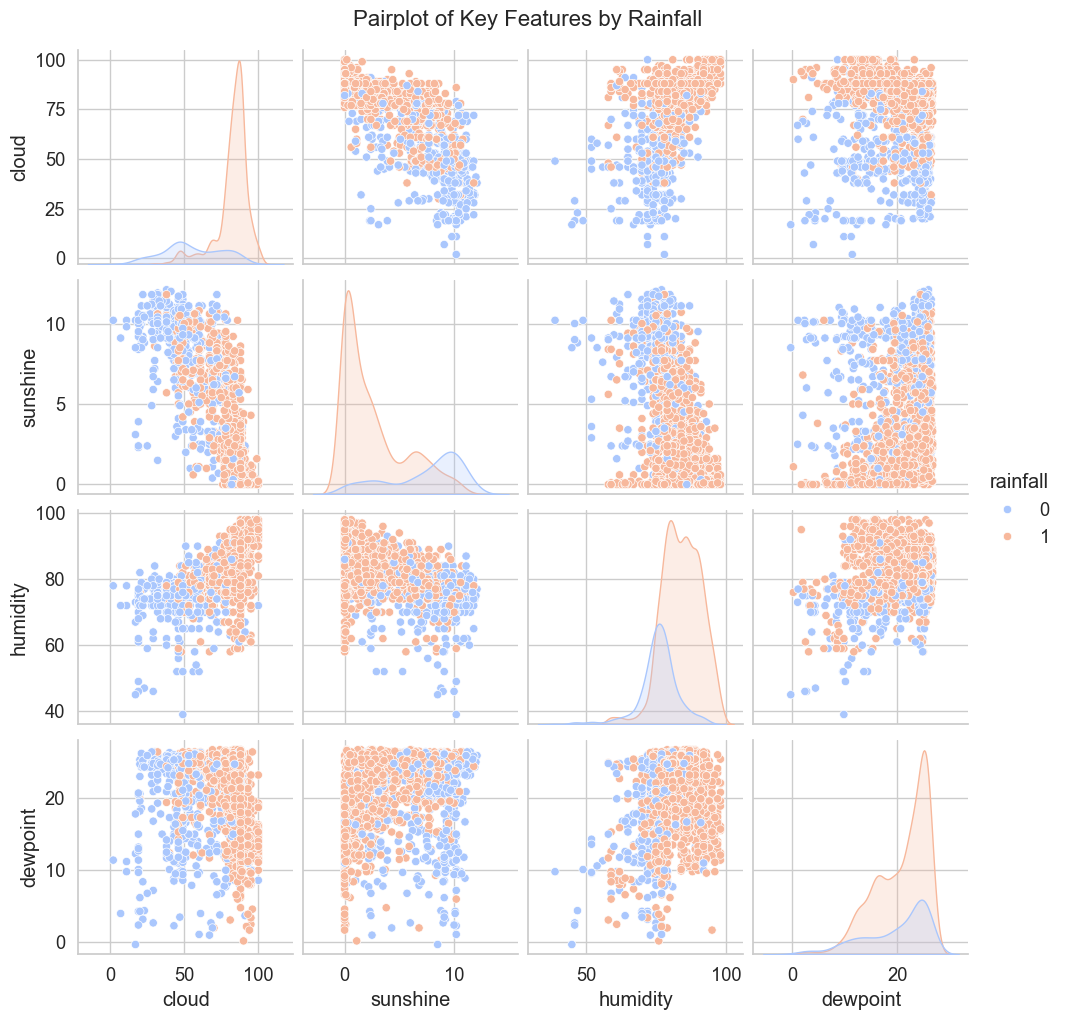

In [20]:
# Pairplot for key features
key_features = ['cloud', 'sunshine', 'humidity', 'dewpoint', 'rainfall']
sns.pairplot(df_train[key_features], hue='rainfall', palette='coolwarm', diag_kind='kde')
plt.suptitle('Pairplot of Key Features by Rainfall', y=1.02, fontsize=16)
plt.show()

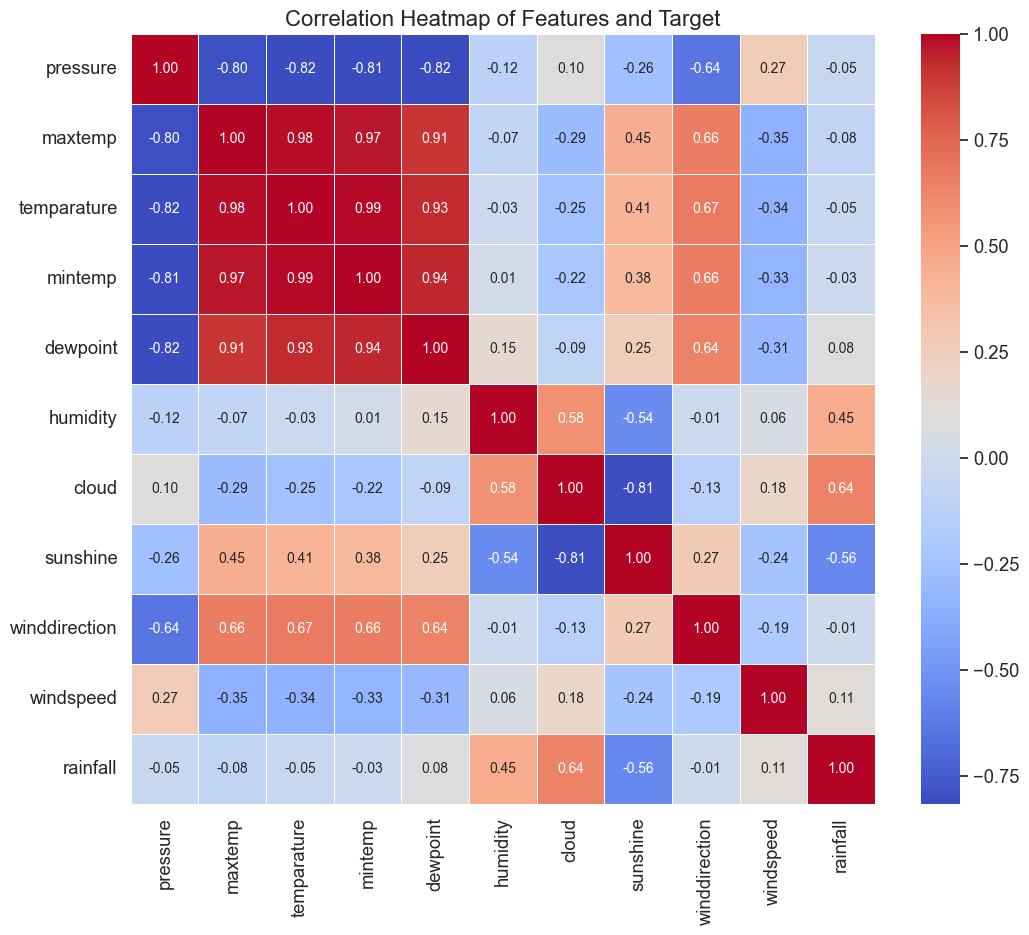

In [21]:
# Correlation heatmap
plt.figure(figsize=(12, 10))
corr_matrix = df_train[numerical_variables + ['rainfall']].corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5, annot_kws={"size": 10})
plt.title('Correlation Heatmap of Features and Target', fontsize=16)
plt.show()

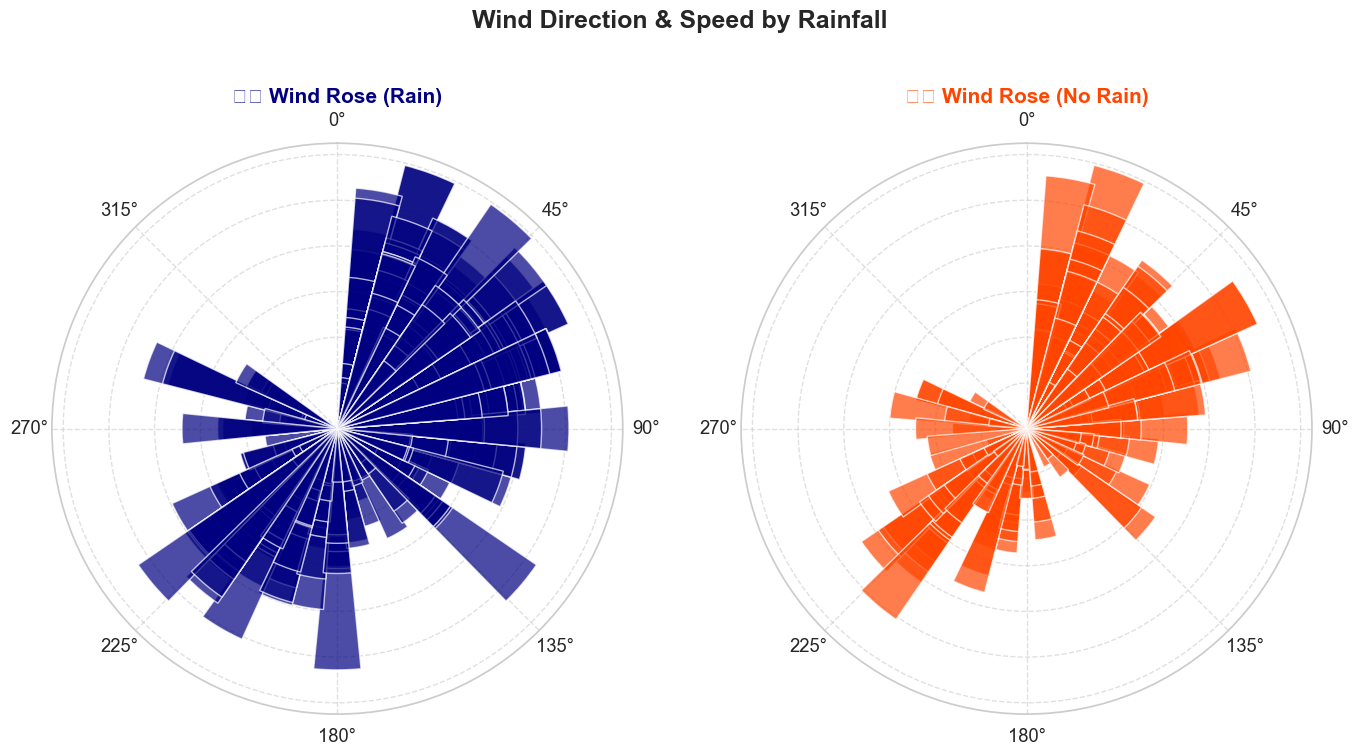

In [26]:
# Setup
fig, axes = plt.subplots(1, 2, subplot_kw={'projection': 'polar'}, figsize=(14, 7))
bar_width = np.pi / 16  # Narrower bars

# Common settings
for ax in axes:
    ax.set_theta_direction(-1)
    ax.set_theta_offset(np.pi / 2.0)
    ax.set_yticklabels([])
    ax.grid(True, linestyle='--', alpha=0.6)

# Rain data
rain_data = df_train[df_train['rainfall'] == 1]
axes[0].bar(
    np.deg2rad(rain_data['winddirection']), 
    rain_data['windspeed'], 
    width=bar_width, color='navy', alpha=0.7, edgecolor='white'
)
axes[0].set_title('🌧️ Wind Rose (Rain)', fontsize=15, fontweight='bold', color='navy')

# No Rain data
no_rain_data = df_train[df_train['rainfall'] == 0]
axes[1].bar(
    np.deg2rad(no_rain_data['winddirection']), 
    no_rain_data['windspeed'], 
    width=bar_width, color='orangered', alpha=0.7, edgecolor='white'
)
axes[1].set_title('☀️ Wind Rose (No Rain)', fontsize=15, fontweight='bold', color='orangered')

plt.suptitle('Wind Direction & Speed by Rainfall', fontsize=18, fontweight='bold', y=1.05)
plt.tight_layout()
plt.show()


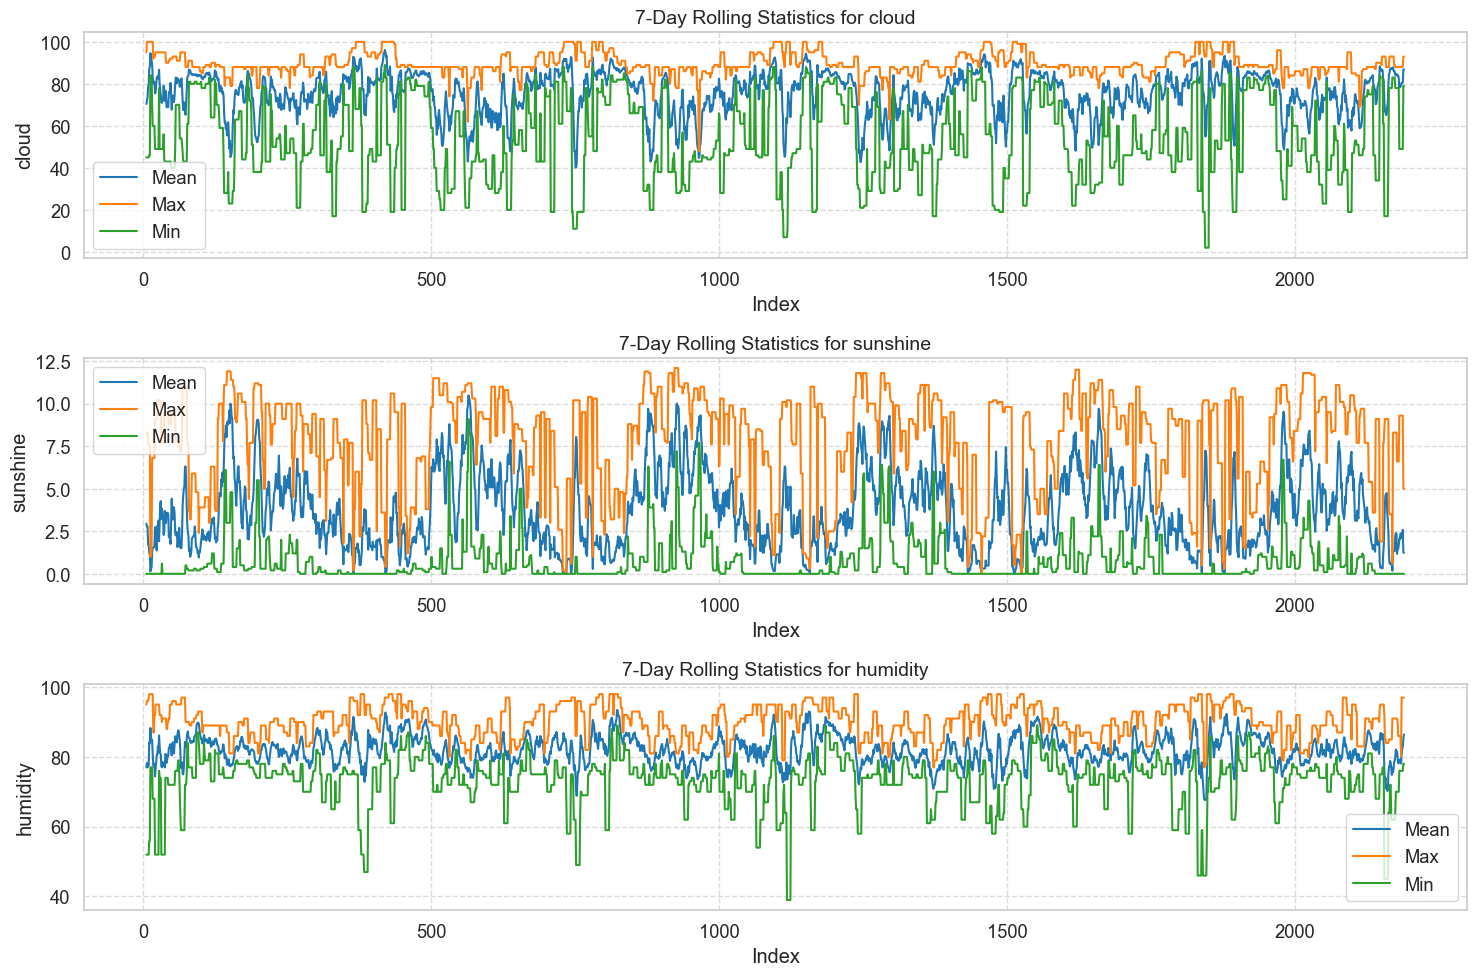

In [27]:
# Rolling statistics for key features
key_features = ['cloud', 'sunshine', 'humidity']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

plt.figure(figsize=(15, 10))
for i, feature in enumerate(key_features, 1):
    plt.subplot(3, 1, i)
    rolling_mean = df_train[feature].rolling(window=7).mean()
    rolling_max = df_train[feature].rolling(window=7).max()
    rolling_min = df_train[feature].rolling(window=7).min()
    plt.plot(rolling_mean, label='Mean', color=colors[0])
    plt.plot(rolling_max, label='Max', color=colors[1])
    plt.plot(rolling_min, label='Min', color=colors[2])
    plt.title(f'7-Day Rolling Statistics for {feature}', fontsize=14)
    plt.xlabel('Index')
    plt.ylabel(feature)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [34]:
# Feature Engineering Function
def preprocess_weather_data(data):
    data["dew_humidity"] = data["dewpoint"] * data["humidity"]
    data["cloud_windspeed"] = data["cloud"] * data["windspeed"]
    data["cloud_to_humidity"] = data["cloud"] / data["humidity"]
    data["temp_to_sunshine"] = data["sunshine"] / data["temparature"]
    data["wind_temp_interaction"] = data["windspeed"] * data["temparature"]
    data["cloud_sun_ratio"] = data["cloud"] / (data["sunshine"] + 1)
    data["dew_humidity/sun"] = data["dewpoint"] * data["humidity"] / (data["sunshine"] + 1)
    data["dew_humidity_+"] = data["dewpoint"] * data["humidity"]
    data["humidity_sunshine_*"] = data["humidity"] * data["sunshine"]
    data["cloud_humidity/pressure"] = (data["cloud"] * data["humidity"]) / data["pressure"]
    data['month'] = ((data['day'] - 1) // 30 + 1).clip(upper=12)
    data['season'] = data['month'].apply(lambda x: 1 if 3 <= x <= 5 else 2 if 6 <= x <= 8 else 3 if 9 <= x <= 11 else 0)
    data['season_cloud_trend'] = data['cloud'] * data['season']
    data['season_cloud_deviation'] = data['cloud'] - data.groupby('season')['cloud'].transform('mean')
    data['season_temperature'] = data['temparature'] * data['season']
    data = data.drop(columns=["month", "maxtemp", "winddirection", "humidity", "temparature", "pressure", "day", "season"])
    return data

# Apply to train and test datasets
df_train_processed = preprocess_weather_data(df_train.copy())
df_test_processed = preprocess_weather_data(df_test.copy())

In [35]:
# Prepare features and target
X = df_train_processed.drop(['rainfall', 'id'], axis=1)
y = df_train_processed['rainfall']
X_test = df_test_processed.drop(['id'], axis=1)

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)

CatBoost: AUC = 0.8829


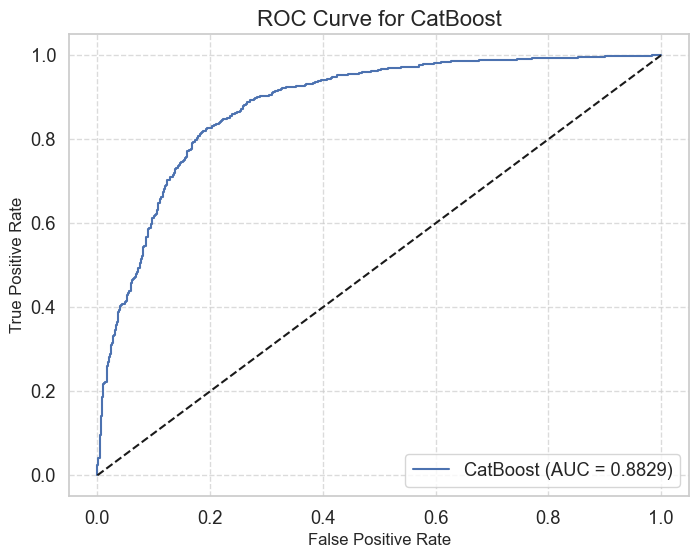

In [36]:
# Define models
models = {
    "CatBoost": CatBoostClassifier(random_state=42, verbose=0, iterations=200, learning_rate=0.1, depth=6)
}

# Train and evaluate CatBoost (best model from previous analysis)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
auc_scores = {}
roc_curves = {}

for name, model in models.items():
    oof_preds = np.zeros(len(y))
    for train_idx, val_idx in skf.split(X_scaled, y):
        X_train, X_val = X_scaled[train_idx], X_scaled[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        model.fit(X_train, y_train)
        oof_preds[val_idx] = model.predict_proba(X_val)[:, 1]
    auc_score = roc_auc_score(y, oof_preds)
    auc_scores[name] = auc_score
    fpr, tpr, _ = roc_curve(y, oof_preds)
    roc_curves[name] = (fpr, tpr, auc_score)
    print(f"{name}: AUC = {auc_score:.4f}")

# Plot ROC curve
plt.figure(figsize=(8, 6))
for name, (fpr, tpr, auc_score) in roc_curves.items():
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc_score:.4f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.title("ROC Curve for CatBoost", fontsize=16)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

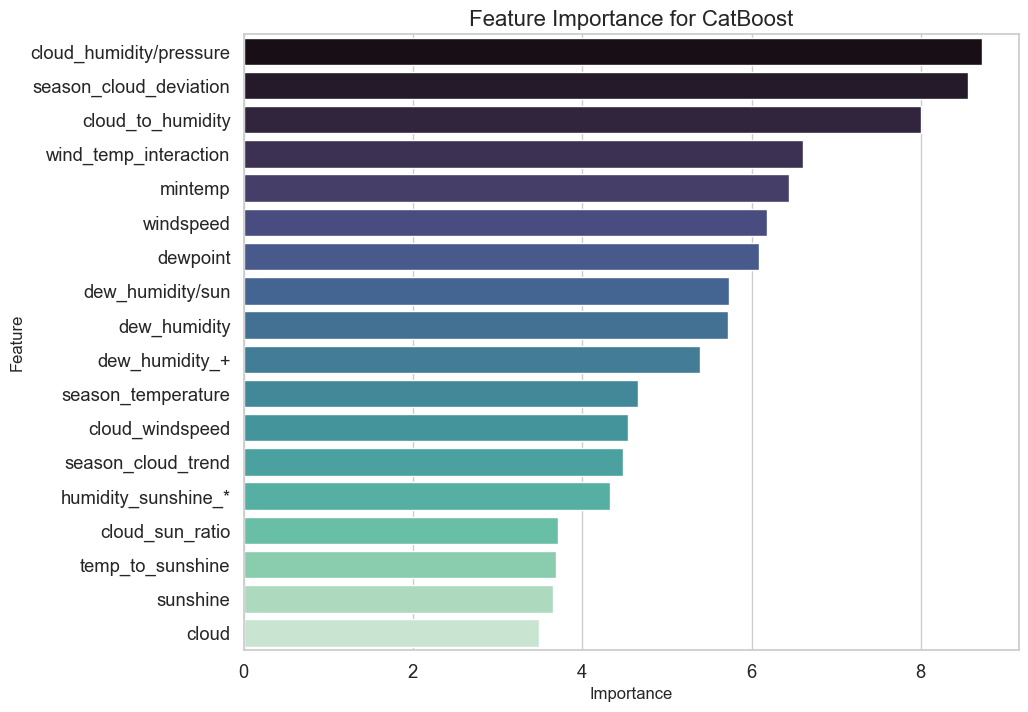

In [37]:
# Feature importance for CatBoost
feature_names = X.columns
feature_importance = models["CatBoost"].feature_importances_
feature_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
feature_df = feature_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_df, palette="mako")
plt.title('Feature Importance for CatBoost', fontsize=16)
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.show()

In [38]:
# Save the model and scaler
import pickle
with open("catboost_model.pkl", "wb") as f:
    pickle.dump(models["CatBoost"], f)
with open("scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)
print("Model and scaler saved as 'catboost_model.pkl' and 'scaler.pkl'.")

Model and scaler saved as 'catboost_model.pkl' and 'scaler.pkl'.


In [ ]:
# # Generate test predictions
# test_preds = models["CatBoost"].predict_proba(X_test_scaled)[:, 1]

# # Create submission file
# submission = pd.DataFrame({'id': df_test['id'], 'rainfall': test_preds})
# submission.to_csv("./Submission File/submission_go.csv", index=False)
# print("\nSubmission file saved as 'submission_go.csv'.")
# display(submission.head())


Submission file saved as 'submission_gio.csv'.


,id,rainfall
0,2190,0.996986
1,2191,0.996994
2,2192,0.987097
3,2193,0.114401
4,2194,0.050326
